In [2]:
from dataclasses import dataclass, field
from vi import Agent, Config, Simulation, HeadlessSimulation
import pygame as pg
from pygame import Vector2
import os
import numpy as np
import random
from multiprocessing import Pool
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

pygame 2.6.1 (SDL 2.28.4, Python 3.13.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)
frame_count = 0

def save_frame(screen):
    global frame_count
    pg.image.save(screen, os.path.join(frame_dir, f"frame_{frame_count:05d}.png"))
    frame_count += 1

In [4]:
class RecordingSimulation(Simulation):
    def __init__(self, config):
        super().__init__(config)
        self.frame_count = 0
        os.makedirs("frames", exist_ok=True)

    def after_update(self) -> None:
        # Draw everything to the screen
        self._all.draw(self._screen)

        if self.config.visualise_chunks:
            self.__visualise_chunks()

        # Save current frame as an image
        # pg.image.save(self._screen, f"frames/frame_{self.frame_count:05d}.png")
        num_predator = len([agent for agent in self._all if isinstance(agent, Predator)])
        if num_predator == 0:
            self.stop()
        # Update the screen with the new image
        pg.display.flip()
        if random.random() < self.config.grass_spawn_prob:
            self.spawn_agent(Grass, images=["images/Grass.jpg"])

        
            
        self._clock.tick(self.config.fps_limit)

        current_fps = self._clock.get_fps()
        if current_fps > 0:
            self._metrics.fps._push(current_fps)

            if self.config.print_fps:
                print(f"FPS: {current_fps:.1f}")  # noqa: T201

        # Increment a frame counter (you may need to initialize it somewhere)
        self.frame_count += 1


In [5]:
@dataclass
class PPConfig(Config):
    #desired initial populations
    initial_prey: int = 100
    initial_predators: int = 50
    initial_grass: int = 20
    grass_spawn_prob: float = 0.3

    #parameters of the Lotka-Volterra equations
    alpha = 0.0055    # slower prey reproduction
    beta = 0.015     # more effective predators
    delta = 0.8     # predator reproduction chance
    gamma = 0.005    # predator death chance

config = PPConfig(image_rotation = True, movement_speed = 3.0, radius = 25, duration = 60*60*10, fps_limit = 0)
    

In [6]:
class Prey(Agent):
    def on_spawn(self):
        self.flee_strength = 1.5
        self.join_strength = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 50
        self.energy_level = 1.0
        self.energy_gain_from_grass = 0.03
        self.energy_decay = 0.01
        self.rabbit_speed_boost = 1.0
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()

        if random.random() < self.config.alpha:
            self.reproduce()

        flee_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())
        nearby_grasses = [agent for agent, _ in neighbors if isinstance(agent, Grass)]
        if any(isinstance(agent, Predator) for agent, _ in neighbors):
            self.state = "Flee"
        elif nearby_grasses != []:
            self.state = "Eat"
        else:
            self.state = "Wander"


        if self.state == "Flee":
            self.wander_direction_cooldown = 0
            predators_nerby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Predator)]
            for predator, dist in predators_nerby:
                if dist == 0:
                    dist = 0.001
                direction = self.pos - predator.pos
                if dist > 0:
                    direction = direction / dist
                force_magnitude = self.flee_strength / dist
                flee_force += direction * force_magnitude
            
            self.move = flee_force
            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed * self.rabbit_speed_boost

        elif self.state == "Eat":
            closest_grass = min(nearby_grasses, key=lambda agent: (agent.pos - self.pos).length())
            direction = closest_grass.pos - self.pos
            if direction.length() > 0:
                direction = direction.normalize()
            self.move = direction * self.config.movement_speed * self.rabbit_speed_boost
            closest_grass.kill()
            self.energy_level += self.energy_gain_from_grass
        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed * self.rabbit_speed_boost
            else:
                self.wander_direction_cooldown -= 1
            
        self.pos += self.move
        self.energy_level -= self.energy_decay
        self.rabbit_speed_boost = self.energy_level
        if self.energy_level <= 0:
            self.kill()

In [7]:
class Predator(Agent):
    def on_spawn(self):
        self.random_move_strength = 1.0
        self.predator_speed_boost = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 0
        self.energy_level = 1.0  # Energy level for the predator
        self.energy_level_decay_rate = 0.03  # Rate at which energy decays over time
        self.energy_level_gain_from_prey = 0.5  # Energy gained from consuming
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()
        if random.random() < self.config.gamma or self.energy_level <= 0:
            self.kill()
            return
        
        attract_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())

        if any(isinstance(agent, Prey) for agent, _ in neighbors):
            self.state = "Hunt"
        else:
            self.state = "Wander"

        if self.state == "Hunt":
            self.wander_direction_cooldown = 0
            prey_nearby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Prey)]
            the_closest_prey, closest_dist = min(prey_nearby, key=lambda x: x[1])
            if closest_dist == 0:
                    closest_dist = 0.001
            direction = the_closest_prey.pos - self.pos
                
            if closest_dist > 0:
                direction = direction / closest_dist

            force_magnitude = 1.0 / closest_dist
            attract_force += direction * force_magnitude
            if random.random() < self.config.beta and the_closest_prey.is_alive():
                the_closest_prey.kill()
                self.energy_level += self.energy_level_gain_from_prey
                if random.random() < self.config.delta:
                    self.reproduce()
            
            self.move = attract_force

            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            
                

        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            else:
                self.wander_direction_cooldown -= 1
        
        self.pos += self.move
        self.energy_level -= self.energy_level_decay_rate
        self.predator_speed_boost = self.energy_level

In [8]:
class Grass(Agent):
    def on_spawn(self):
        #TODO: implement rotation so grasses always spawn upright
        return super().on_spawn()

In [ ]:
(
    RecordingSimulation(
        config
    )
    .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
    .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
    .batch_spawn_agents(config.initial_grass, Grass, images=["images/Grass.jpg"])
    .run()
)

: 

In [9]:
class HeadlessSimulationRefined(HeadlessSimulation):
   def __init__(self, config):
      super().__init__(config)
      self.frame_count = 0
      self.prey_predator__per_frame = []

   def after_update(self) -> None:
      # Increment a frame counter (you may need to initialize it somewhere)
      
      # if self.frame_count % 10 == 0:
      num_prey = len([agent for agent in self._all if isinstance(agent, Prey)])
      num_predator = len([agent for agent in self._all if isinstance(agent, Predator)])
      self.prey_predator__per_frame.append((num_prey, num_predator))
      if random.random() < self.config.grass_spawn_prob:
         self.spawn_agent(Grass, images=["images/Grass.jpg"])
      if num_predator == 0:
         self.stop()
      if self.frame_count % 100 == 0:
            print(num_prey, num_predator)
      self.frame_count += 1

   def run(self):
        """Run the simulation until it's ended by closing the window or when the `vi.config.Schema.duration` has elapsed."""
        self._running = True

        while self._running:
            self.tick()

        return self.prey_predator__per_frame

In [10]:
def run_simulation(config: Config) -> pl.DataFrame:
    return (
        HeadlessSimulationRefined(config)
        .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
        .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
        .batch_spawn_agents(config.initial_grass, Grass, images=["images/Grass.jpg"])
        .run()
    )

101 47


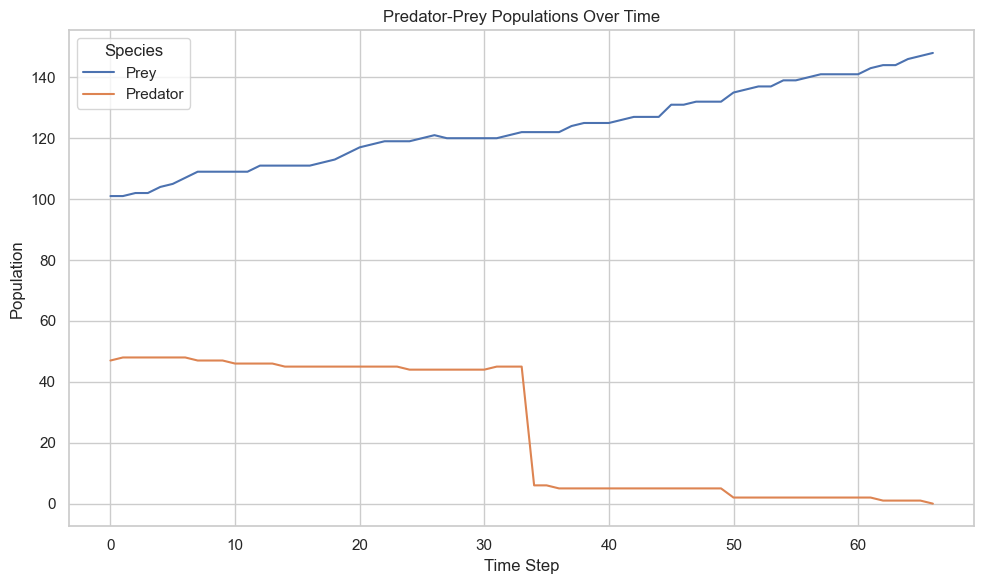

In [11]:
agents_per_frame = run_simulation(config)
df = pd.DataFrame(agents_per_frame, columns=['Prey', 'Predator'])
df['Time'] = range(len(df)) 

df_melted = df.melt(id_vars='Time', value_vars=['Prey', 'Predator'],
                    var_name='Species', value_name='Population')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Time', y='Population', hue='Species')
plt.title("Predator-Prey Populations Over Time")
plt.xlabel("Time Step")
plt.ylabel("Population")
plt.legend(title="Species")
plt.tight_layout()
plt.show()